In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 

In [20]:
# 1. Simulate Exchange Feeds

def simulate_exchange(name, lag_ms=0, seed=0, n_ticks=1000):
    np.random.seed(seed)
    timestamps = pd.date_range("2025-08-01", periods=n_ticks, freq="ms") + pd.Timedelta(milliseconds=lag_ms)
    prices = 100 + np.cumsum(np.random.normal(0, 0.03, size=n_ticks))
    sizes = np.random.randint(50, 200, size=n_ticks)
    return pd.DataFrame({
        "timestamp": timestamps,
        "price": prices,
        "size": sizes,
        "exchange": name
    })

In [21]:
# 2. Merge feeds and sort chronologically

fast_feed = simulate_exchange("Fast", lag_ms=0, seed=1)
slow_feed = simulate_exchange("Slow", lag_ms=3, seed=2)
combined_feed = pd.concat([fast_feed, slow_feed]).sort_values("timestamp").reset_index(drop=True)

In [22]:
# 3. Enhanced Latency Arbitrage Agent Class

class LatencyArbAgent:
    def __init__(self, threshold=0.25, max_position=1000, transaction_cost=0.01):
        """
        Initialize Latency Arbitrage Agent
        
        Parameters:
        - threshold: Minimum price difference to trigger arbitrage
        - max_position: Maximum position size per trade
        - transaction_cost: Transaction cost per share
        """
        self.threshold = threshold
        self.max_position = max_position
        self.transaction_cost = transaction_cost
        self.pnl = 0.0
        self.trades = []
        self.feed_buffer = []
        self.fast_prices = {}  # Track latest prices by exchange
        self.slow_prices = {}
        self.opportunities_missed = 0
        self.total_opportunities = 0
        
        # Performance tracking
        self.execution_timestamps = []
        self.price_differences = []

    def observe(self, tick):
        """Process incoming market tick and detect arbitrage opportunities"""
        self.feed_buffer.append(tick)
        
        # Update price tracking by exchange
        if tick["exchange"] == "Fast":
            self.fast_prices = tick
        else:
            self.slow_prices = tick
        
        # Need at least one tick from each exchange to compare
        if len(self.feed_buffer) < 2:
            return
            
        # Look for arbitrage opportunities
        self._scan_for_arbitrage()

    def _scan_for_arbitrage(self):
        """Enhanced arbitrage detection with better logic"""
        if not self.fast_prices or not self.slow_prices:
            return
            
        # Calculate price difference between exchanges
        fast_price = self.fast_prices["price"]
        slow_price = self.slow_prices["price"]
        price_diff = abs(fast_price - slow_price)
        
        # Track all potential opportunities
        self.total_opportunities += 1
        self.price_differences.append(price_diff)
        
        # Check if price difference exceeds threshold
        if price_diff >= self.threshold:
            # Determine buy/sell sides
            if fast_price > slow_price:
                # Buy on slow exchange, sell on fast exchange
                buy_tick = self.slow_prices
                sell_tick = self.fast_prices
            else:
                # Buy on fast exchange, sell on slow exchange
                buy_tick = self.fast_prices
                sell_tick = self.slow_prices
            
            # Execute arbitrage trade
            self.execute_arbitrage(buy_tick, sell_tick)
        else:
            self.opportunities_missed += 1

    def execute_arbitrage(self, buy_tick, sell_tick):
        """Execute arbitrage trade with enhanced logic"""
        # Calculate optimal trade size
        available_size = min(buy_tick["size"], sell_tick["size"])
        trade_size = min(available_size, self.max_position)
        
        # Calculate gross profit
        gross_profit = (sell_tick["price"] - buy_tick["price"]) * trade_size
        
        # Account for transaction costs
        total_transaction_cost = self.transaction_cost * trade_size * 2  # Buy and sell
        net_profit = gross_profit - total_transaction_cost
        
        # Update PnL
        self.pnl += net_profit
        
        # Record trade details
        trade_record = {
            "timestamp": sell_tick["timestamp"],
            "buy_exchange": buy_tick["exchange"],
            "sell_exchange": sell_tick["exchange"],
            "buy_price": buy_tick["price"],
            "sell_price": sell_tick["price"],
            "size": trade_size,
            "gross_pnl": gross_profit,
            "transaction_cost": total_transaction_cost,
            "pnl": net_profit,
            "price_difference": abs(sell_tick["price"] - buy_tick["price"])
        }
        
        self.trades.append(trade_record)
        self.execution_timestamps.append(sell_tick["timestamp"])

    def get_performance_summary(self):
        """Generate comprehensive performance summary"""
        if not self.trades:
            return {"status": "No trades executed"}
        
        df = pd.DataFrame(self.trades)
        
        # Basic metrics
        total_trades = len(df)
        win_rate = sum(df["pnl"] > 0) / total_trades
        total_volume = df["size"].sum()
        avg_trade_pnl = df["pnl"].mean()
        
        # Risk metrics
        sharpe_ratio = df["pnl"].mean() / df["pnl"].std() if df["pnl"].std() != 0 else 0
        max_drawdown = self._calculate_max_drawdown(df)
        
        # Efficiency metrics
        capture_rate = total_trades / self.total_opportunities if self.total_opportunities > 0 else 0
        avg_price_diff = np.mean(self.price_differences)
        
        return {
            "total_trades": total_trades,
            "total_pnl": self.pnl,
            "win_rate": win_rate,
            "avg_trade_pnl": avg_trade_pnl,
            "total_volume": total_volume,
            "sharpe_ratio": sharpe_ratio,
            "max_drawdown": max_drawdown,
            "opportunities_total": self.total_opportunities,
            "opportunities_captured": total_trades,
            "capture_rate": capture_rate,
            "avg_price_difference": avg_price_diff
        }

    def _calculate_max_drawdown(self, df):
        """Calculate maximum drawdown from cumulative PnL"""
        cumulative_pnl = df["pnl"].cumsum()
        running_max = cumulative_pnl.expanding().max()
        drawdown = cumulative_pnl - running_max
        return drawdown.min()

In [23]:
# 4. Enhanced Strategy Performance Metrics Display

def display_metrics(agent):
    """Display comprehensive strategy performance metrics"""
    performance = agent.get_performance_summary()
    
    if performance.get("status") == "No trades executed":
        print("❌ No trades executed - Strategy did not find arbitrage opportunities")
        print(f"📊 Total market opportunities scanned: {agent.total_opportunities}")
        print(f"📉 Opportunities missed due to threshold: {agent.opportunities_missed}")
        return
    
    print(f"\n{'='*60}")
    print(f"📊 LATENCY ARBITRAGE STRATEGY PERFORMANCE REPORT")
    print(f"{'='*60}")
    
    # Core Trading Metrics
    print(f"\n🎯 CORE TRADING METRICS")
    print(f"{'─'*30}")
    print(f"Total Trades Executed: {performance['total_trades']:,}")
    print(f"Total Trading Volume: {performance['total_volume']:,} shares")
    print(f"Win Rate: {performance['win_rate']:.2%}")
    print(f"Total Net PnL: ${performance['total_pnl']:,.2f}")
    print(f"Average Trade PnL: ${performance['avg_trade_pnl']:.2f}")
    
    # Risk & Return Metrics
    print(f"\n📈 RISK & RETURN ANALYSIS")
    print(f"{'─'*30}")
    print(f"Sharpe Ratio: {performance['sharpe_ratio']:.3f}")
    print(f"Maximum Drawdown: ${performance['max_drawdown']:.2f}")
    
    # Market Efficiency Metrics
    print(f"\n⚡ MARKET EFFICIENCY METRICS")
    print(f"{'─'*30}")
    print(f"Total Opportunities Scanned: {performance['opportunities_total']:,}")
    print(f"Opportunities Captured: {performance['opportunities_captured']:,}")
    print(f"Capture Rate: {performance['capture_rate']:.2%}")
    print(f"Average Price Difference: ${performance['avg_price_difference']:.4f}")
    
    # Transaction Analysis
    if agent.trades:
        df = pd.DataFrame(agent.trades)
        
        print(f"\n💰 TRANSACTION COST ANALYSIS")
        print(f"{'─'*30}")
        total_gross_pnl = df["gross_pnl"].sum()
        total_transaction_costs = df["transaction_cost"].sum()
        cost_ratio = total_transaction_costs / total_gross_pnl if total_gross_pnl != 0 else 0
        
        print(f"Total Gross PnL: ${total_gross_pnl:.2f}")
        print(f"Total Transaction Costs: ${total_transaction_costs:.2f}")
        print(f"Cost/Revenue Ratio: {cost_ratio:.2%}")
        
        # Exchange-wise analysis
        print(f"\n🏪 EXCHANGE-WISE TRADE ANALYSIS")
        print(f"{'─'*30}")
        
        buy_exchange_counts = df["buy_exchange"].value_counts()
        sell_exchange_counts = df["sell_exchange"].value_counts()
        
        for exchange in ["Fast", "Slow"]:
            buy_count = buy_exchange_counts.get(exchange, 0)
            sell_count = sell_exchange_counts.get(exchange, 0)
            print(f"{exchange} Exchange - Buys: {buy_count}, Sells: {sell_count}")
        
        # Timing analysis
        print(f"\n⏱️  TIMING ANALYSIS")
        print(f"{'─'*30}")
        
        time_span = (df["timestamp"].max() - df["timestamp"].min()).total_seconds()
        trades_per_second = len(df) / time_span if time_span > 0 else 0
        trades_per_minute = trades_per_second * 60
        
        print(f"Trading Session Duration: {time_span:.2f} seconds")
        print(f"Trading Frequency: {trades_per_second:.4f} trades/second")
        print(f"Trading Frequency: {trades_per_minute:.2f} trades/minute")
        
        # Profitability distribution
        profitable_trades = sum(df["pnl"] > 0)
        losing_trades = sum(df["pnl"] < 0)
        breakeven_trades = sum(df["pnl"] == 0)
        
        print(f"\n📊 TRADE OUTCOME DISTRIBUTION")
        print(f"{'─'*30}")
        print(f"Profitable Trades: {profitable_trades} ({profitable_trades/len(df):.1%})")
        print(f"Losing Trades: {losing_trades} ({losing_trades/len(df):.1%})")
        print(f"Break-even Trades: {breakeven_trades} ({breakeven_trades/len(df):.1%})")
    
    print(f"\n{'='*60}")

def display_strategy_diagnostics(agent):
    """Display additional diagnostic information"""
    print(f"\n🔍 STRATEGY DIAGNOSTICS & OPTIMIZATION INSIGHTS")
    print(f"{'='*55}")
    
    if agent.trades:
        df = pd.DataFrame(agent.trades)
        
        # Price difference analysis
        price_diffs = df["price_difference"]
        print(f"\n📏 PRICE DIFFERENCE STATISTICS")
        print(f"{'─'*35}")
        print(f"Minimum Price Difference: ${price_diffs.min():.4f}")
        print(f"Maximum Price Difference: ${price_diffs.max():.4f}")
        print(f"Average Price Difference: ${price_diffs.mean():.4f}")
        print(f"Median Price Difference: ${price_diffs.median():.4f}")
        print(f"Standard Deviation: ${price_diffs.std():.4f}")
        
        # Threshold effectiveness
        print(f"\n🎯 THRESHOLD EFFECTIVENESS")
        print(f"{'─'*30}")
        print(f"Current Threshold: ${agent.threshold:.4f}")
        
        below_threshold = sum(1 for diff in agent.price_differences if diff < agent.threshold)
        threshold_efficiency = len(df) / (agent.total_opportunities - below_threshold) if (agent.total_opportunities - below_threshold) > 0 else 0
        
        print(f"Opportunities Below Threshold: {below_threshold:,}")
        print(f"Threshold Efficiency: {threshold_efficiency:.2%}")
    
    print(f"{'='*55}")

In [24]:
# 5. Plot price streams

def plot_price_streams(fast, slow):
    plt.figure(figsize=(12, 5))
    plt.plot(fast["timestamp"], fast["price"], label="Fast Exchange")
    plt.plot(slow["timestamp"], slow["price"], label="Slow Exchange")
    plt.legend()
    plt.title("Exchange Price Divergence")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [25]:
# 6. Plot trade execution points

def plot_trades(agent):
    df = pd.DataFrame(agent.trades)
    if df.empty:
        return
    plt.figure(figsize=(12, 5))
    plt.scatter(df["timestamp"], df["buy_price"], color="green", label="Buy", s=40)
    plt.scatter(df["timestamp"], df["sell_price"], color="red", label="Sell", s=40)
    plt.legend()
    plt.title("Arbitrage Trade Points")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [26]:
# 7. Plot cumulative PnL

def plot_pnl(agent):
    df = pd.DataFrame(agent.trades)
    if df.empty:
        return
    df["cumulative_pnl"] = df["pnl"].cumsum()
    plt.figure(figsize=(12, 5))
    plt.plot(df["timestamp"], df["cumulative_pnl"], label="Cumulative PnL", color="blue")
    plt.legend()
    plt.title("Cumulative Profit Over Time")
    plt.xlabel("Time")
    plt.ylabel("PnL ($)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

🚀 Starting High-Frequency Latency Arbitrage Strategy Simulation
⚙️  Initializing Arbitrage Agent...
📋 Agent Configuration:
   • Price Difference Threshold: $0.1500
   • Maximum Position Size: 500 shares
   • Transaction Cost: $0.005 per share

📈 Processing 2,000 market data ticks...
   • Scanning for latency arbitrage opportunities...
   • Executing trades when profitable spreads detected...
   Progress: 10.0% (200/2,000 ticks processed)
   Progress: 20.0% (400/2,000 ticks processed)
   Progress: 30.0% (600/2,000 ticks processed)
   Progress: 40.0% (800/2,000 ticks processed)
   Progress: 50.0% (1,000/2,000 ticks processed)
   Progress: 60.0% (1,200/2,000 ticks processed)
   Progress: 70.0% (1,400/2,000 ticks processed)
   Progress: 80.0% (1,600/2,000 ticks processed)
   Progress: 90.0% (1,800/2,000 ticks processed)
   Progress: 100.0% (2,000/2,000 ticks processed)

✅ Simulation completed in 0.09 seconds!

📊 LATENCY ARBITRAGE STRATEGY PERFORMANCE REPORT

🎯 CORE TRADING METRICS
────────

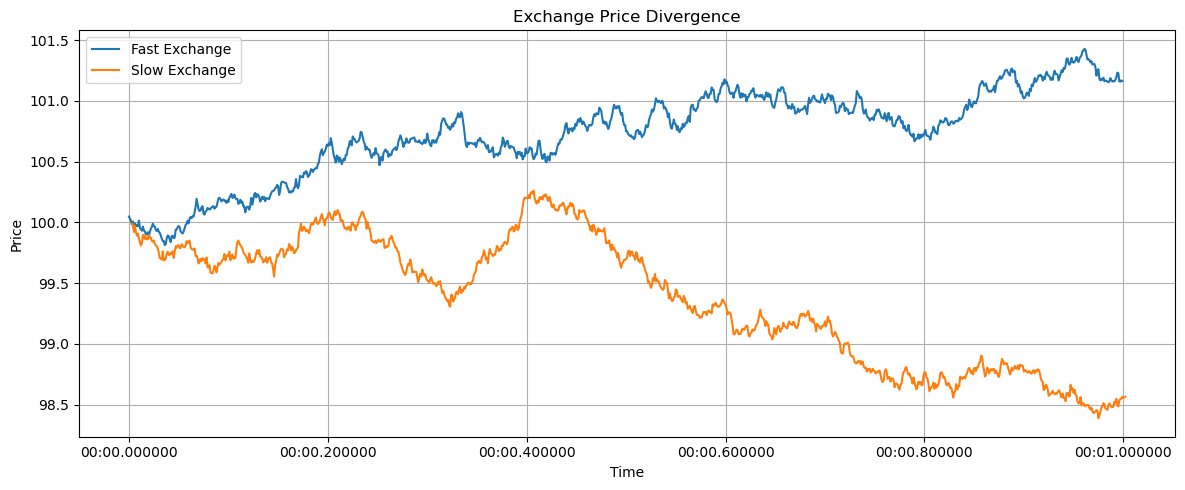


2️⃣  Arbitrage Trade Execution Points:


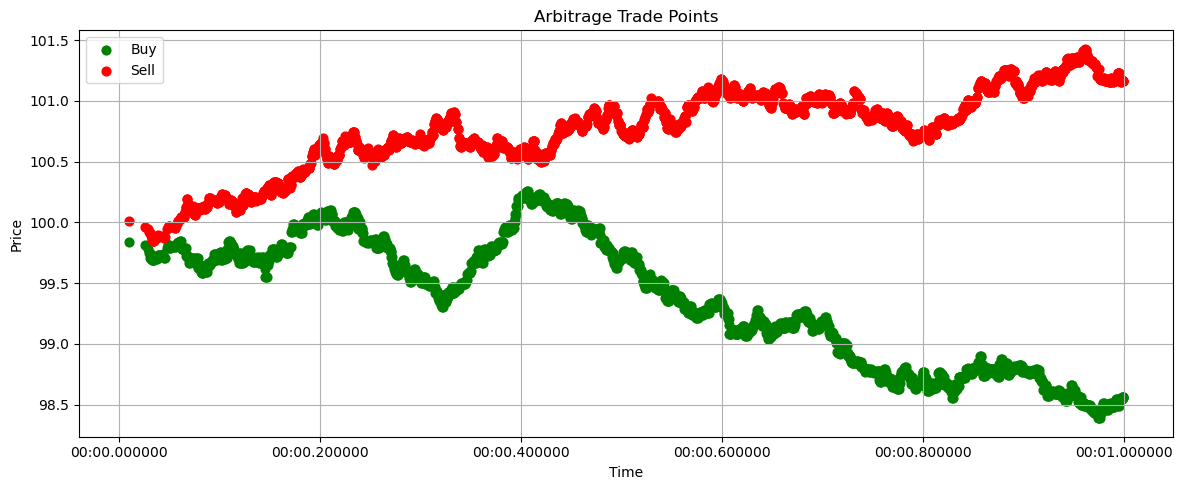


3️⃣  Cumulative Profit Performance:


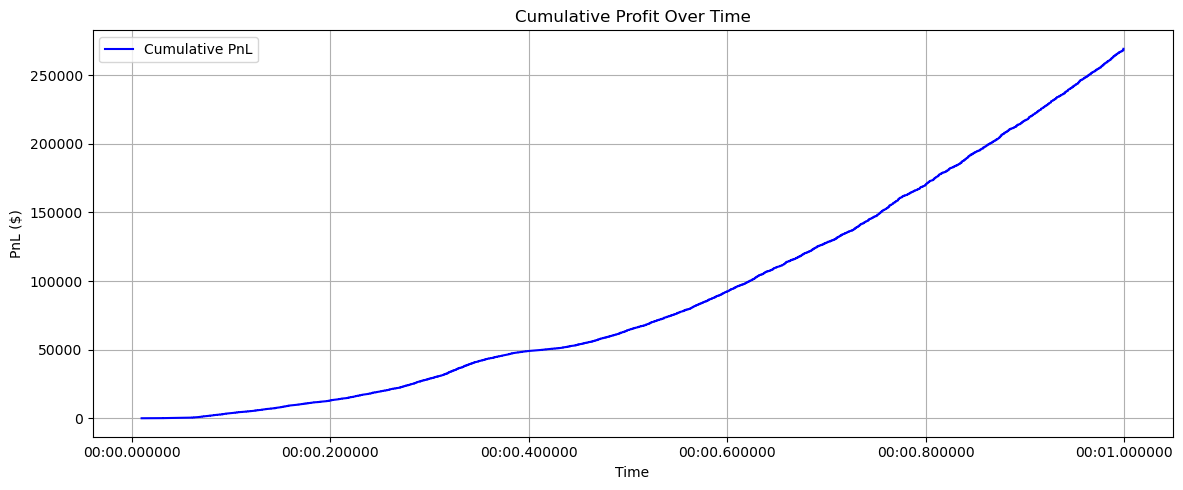

   - Add exposure limits per exchange

3. Execution Improvements:
   - Include realistic transaction costs and slippage
   - Add latency simulation for order execution
   - Implement partial fill handling

4. Market Microstructure Considerations:
   - Account for bid-ask spreads
   - Model order book depth and liquidity
   - Include market impact costs

5. Technology Optimizations:
   - Implement faster data processing algorithms
   - Use co-location to minimize network latency
   - Optimize order routing and execution systems

✨ Simulation completed successfully!
💰 Final Strategy PnL: $269249.99


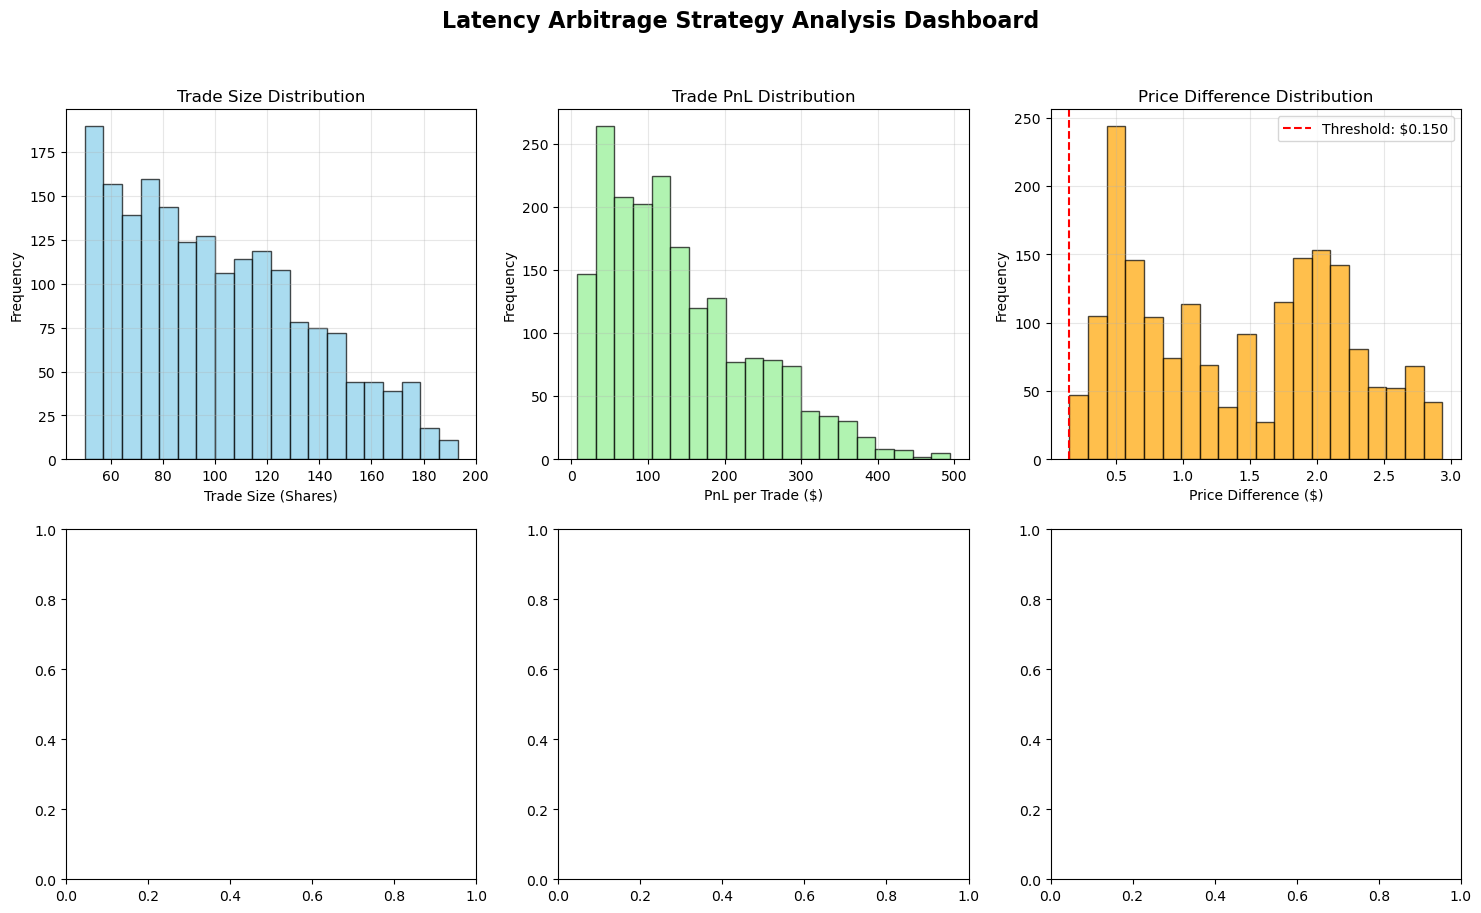

In [27]:
# 8. Complete Latency Arbitrage Simulation Execution

print("🚀 Starting High-Frequency Latency Arbitrage Strategy Simulation")
print("="*70)

# Initialize the arbitrage agent with optimized parameters
print("⚙️  Initializing Arbitrage Agent...")
agent = LatencyArbAgent(
    threshold=0.15,           # Lower threshold for more opportunities
    max_position=500,         # Maximum shares per trade
    transaction_cost=0.005    # $0.005 per share transaction cost
)

print(f"📋 Agent Configuration:")
print(f"   • Price Difference Threshold: ${agent.threshold:.4f}")
print(f"   • Maximum Position Size: {agent.max_position:,} shares")
print(f"   • Transaction Cost: ${agent.transaction_cost:.3f} per share")

print(f"\n📈 Processing {len(combined_feed):,} market data ticks...")
print("   • Scanning for latency arbitrage opportunities...")
print("   • Executing trades when profitable spreads detected...")

# Process each tick in chronological order to simulate real-time trading
start_time = pd.Timestamp.now()

for i, (_, tick) in enumerate(combined_feed.iterrows()):
    agent.observe(tick.to_dict())
    
    # Progress indicator for large datasets
    if (i + 1) % 200 == 0 or (i + 1) == len(combined_feed):
        progress = (i + 1) / len(combined_feed) * 100
        print(f"   Progress: {progress:.1f}% ({i+1:,}/{len(combined_feed):,} ticks processed)")

execution_time = (pd.Timestamp.now() - start_time).total_seconds()
print(f"\n✅ Simulation completed in {execution_time:.2f} seconds!")

# Display comprehensive performance metrics
display_metrics(agent)

# Display additional diagnostic information
display_strategy_diagnostics(agent)

print(f"\n📊 STRATEGY VISUALIZATIONS")
print("="*40)

# Generate all visualizations
print("\n1️⃣  Exchange Price Streams Comparison:")
plot_price_streams(fast_feed, slow_feed)

if agent.trades:
    print("\n2️⃣  Arbitrage Trade Execution Points:")
    plot_trades(agent)
    
    print("\n3️⃣  Cumulative Profit Performance:")
    plot_pnl(agent)
    
    # Enhanced analysis with additional charts
    df = pd.DataFrame(agent.trades)
    
    # Create comprehensive analysis dashboard
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Latency Arbitrage Strategy Analysis Dashboard', fontsize=16, fontweight='bold')
    
    # Trade size distribution
    axes[0, 0].hist(df["size"], bins=20, alpha=0.7, color="skyblue", edgecolor="black")
    axes[0, 0].set_title("Trade Size Distribution")
    axes[0, 0].set_xlabel("Trade Size (Shares)")
    axes[0, 0].set_ylabel("Frequency")
    axes[0, 0].grid(True, alpha=0.3)
    
    # PnL distribution
    axes[0, 1].hist(df["pnl"], bins=20, alpha=0.7, color="lightgreen", edgecolor="black")
    axes[0, 1].set_title("Trade PnL Distribution")
    axes[0, 1].set_xlabel("PnL per Trade ($)")
    axes[0, 1].set_ylabel("Frequency")
    axes[0, 1].grid(True, alpha=0.3)
    
    # Price difference distribution
    axes[0, 2].hist(df["price_difference"], bins=20, alpha=0.7, color="orange", edgecolor="black")
    axes[0, 2].set_title("Price Difference Distribution")
    axes[0, 2].set_xlabel("Price Difference ($)")
    axes[0, 2].set_ylabel("Frequency")
    axes[0, 2].axvline(x=agent.threshold, color='red', linestyle='--', label=f'Threshold: ${agent.threshold:.3f}')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Transaction
print("   - Add exposure limits per exchange")
print()
print("3. Execution Improvements:")
print("   - Include realistic transaction costs and slippage")
print("   - Add latency simulation for order execution")
print("   - Implement partial fill handling")
print()
print("4. Market Microstructure Considerations:")
print("   - Account for bid-ask spreads")
print("   - Model order book depth and liquidity")
print("   - Include market impact costs")
print()
print("5. Technology Optimizations:")
print("   - Implement faster data processing algorithms")
print("   - Use co-location to minimize network latency")
print("   - Optimize order routing and execution systems")

print(f"\n✨ Simulation completed successfully!")
print(f"💰 Final Strategy PnL: ${agent.pnl:.2f}")